In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
df_FD = pd.read_pickle('cleaned_MASTER_dataset.pickle')  # fish details
df_LF = pd.read_pickle('cleaned_LENGTHFREQ_dataset.pickle')  # length frequencies
df_SD = pd.read_pickle('cleaned_LOGBOOK_dataset.pickle')  # logbook / sample data

# Generate Unique IDs - Length Frequencies

In [3]:
# replace non-numeric data with made up site numbers
id_replacements = {
    '1A': 90,
    '1B': 91,
    'EricMcFarlane': 92,
    'JimmyMacFarlane': 93,
    'JohnAlbertCoady': 94
}
# df_LF.loc[df_LF.SITE1.isnull(), 'SITE1'] = 0  # set missing sites to 0
# NOTE: null sites can be set during query (fillna(0))
df_LF = df_LF.replace({'SITE1': id_replacements})

In [4]:
# 'unique' id column (note ambiguities, and solve later)
df_LF['id'] = (
    df_LF.DATETIME.dt.year*1_000_000 
    + df_LF.DATETIME.dt.month*10_000 
    + df_LF.DATETIME.dt.day*100 
    + df_LF.SITE1.fillna(0).astype(int)
).astype('Int64')

# new sample indicator
df_LF['new_sample'] = df_LF.lgth.diff() < 0

# new id indicator
df_LF['new_id'] = df_LF.id.diff() != 0

In [5]:
# update ids for ambiguous entries
duplicated_ids_LF = list(df_LF[~df_LF.new_id & df_LF.new_sample].id)

In [6]:
# only run this once
if df_LF.id.max() < 2_100_000_000:

    # add 1B to duplicate ids
    df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] = df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] + 1_000_000_000

    # add an extra billion to every other id, so that all are now distinct
    previous_lgth = 0
    multiplier = False

    for i, row in df_LF[df_LF.id > 2_900_000_000].iterrows():

        current_lgth = row['lgth']
        if previous_lgth > current_lgth:
            multiplier = not multiplier

        df_LF.loc[i, 'id'] = row.id + 1_000_000_000*multiplier

        previous_lgth = current_lgth

In [7]:
# LOOKS GOOD: check to see if it worked
df_LF[df_LF.id.isin([x + 1_000_000_000 for x in duplicated_ids_LF]) | df_LF.id.isin([x + 2_000_000_000 for x in duplicated_ids_LF])]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id
3102,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,235,1,235,1998-05-01,5,<NA>,<NA>,2998050105,True,True
3103,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,240,1,240,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3104,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,245,4,245,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3105,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,250,2,250,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3106,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,255,3,255,1998-05-01,5,<NA>,<NA>,2998050105,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10848,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,250,25,250,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10849,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,255,13,255,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10850,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,260,1,260,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10851,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,235,2,235,2018-06-13,64,<NA>,<NA>,4018061364,True,False


In [8]:
# GOOD:
df_LF[df_LF.id.isin(duplicated_ids_LF)]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id


# Length Bins

In [9]:
# use the same bins as used in the herring database
df_LF['length_bin_id'] = (df_LF.lgth - df_LF.lgth % 5) / 10

In [10]:
# error check: how many total fish cm (binned)
(df_LF['length_bin_id'] * df_LF['freq']).sum()

5076496.0

In [11]:
gaspereau_lengthfrequency = df_LF.groupby(['id', 'length_bin_id']).sum('freq').reset_index()[['freq', 'length_bin_id', 'id']].rename({
    'freq': 'count', 
    'length_bin_id': 'length_bin_id', 
    'id': 'sample_id'
}, axis=1)

In [12]:
# LOOKS GOOD: error check: how many total fish cm (binned)
(gaspereau_lengthfrequency['length_bin_id'] * gaspereau_lengthfrequency['count']).sum()

5076496.0

# Save the gaspereau_lengthfrequency table

In [20]:
# this can link to herring_lengthbin (it goes from 0 to 200cm - more than enough)
if False:  # change this to overwrite/resave
    gaspereau_lengthfrequency.to_pickle('gaspereau_lengthfrequency.pickle')

In [14]:
# lets look at a few histograms, just to check
sample_ids = gaspereau_lengthfrequency.sample_id.unique()

----------------------------------------------
Histogram: 1999052035


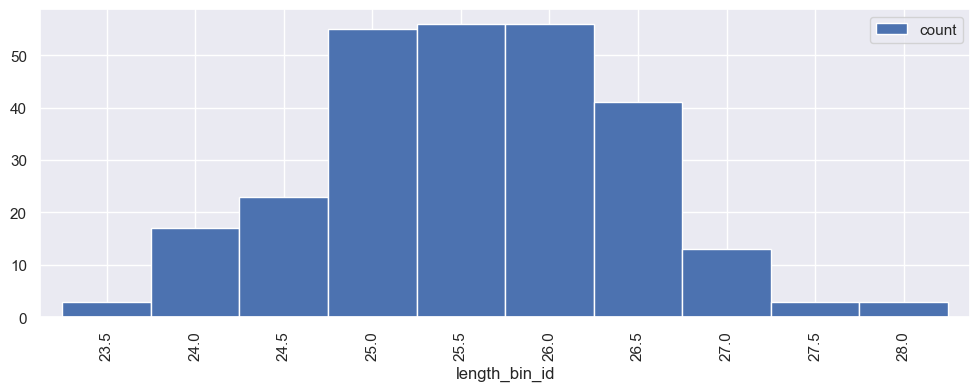

----------------------------------------------
Histogram: 2019062141


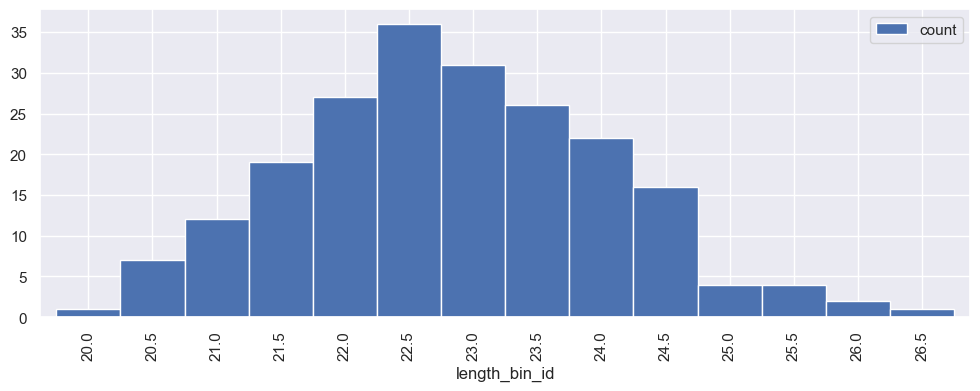

----------------------------------------------
Histogram: 2002051526


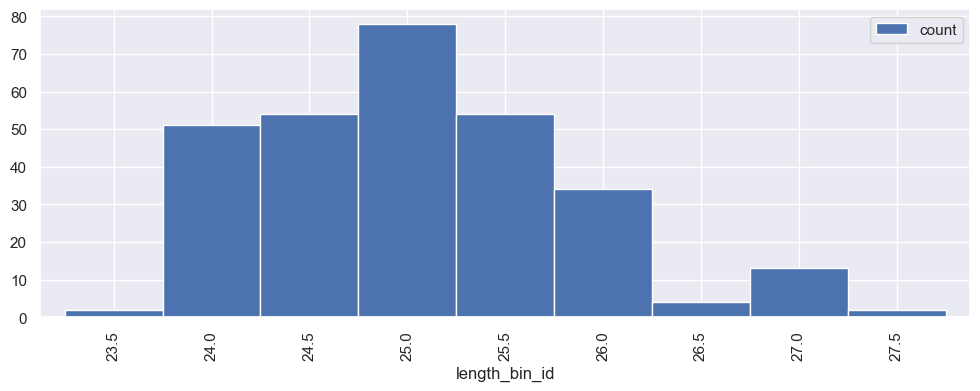

----------------------------------------------
Histogram: 2013052212


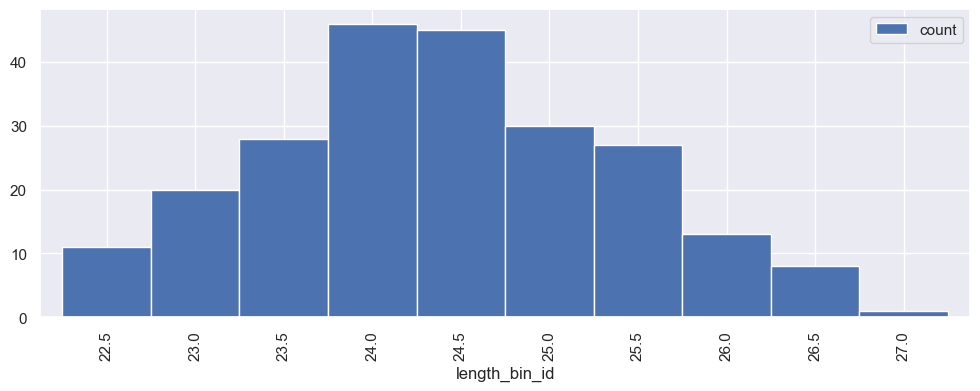

----------------------------------------------
Histogram: 2019052425


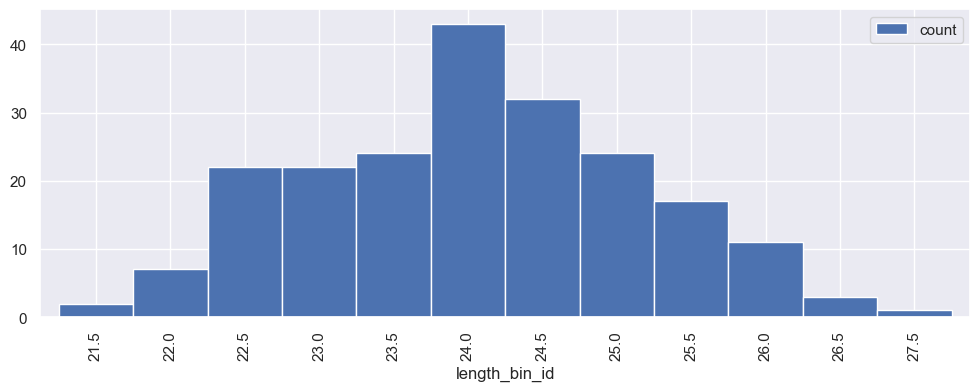

In [15]:
# random samples - check the histogram
for i in range(5):
    sample_id = np.random.choice(sample_ids)
    print('----------------------------------------------\nHistogram:', sample_id)
    gaspereau_lengthfrequency.loc[gaspereau_lengthfrequency.sample_id==sample_id, ['count', 'length_bin_id']].plot(kind='bar', x='length_bin_id', y='count', width=1, figsize=(12,4))
    plt.show()

# Samples

In [16]:
# same site replacements from LF
df_SD = df_SD.replace({'SITE1': id_replacements})

# 'unique' id column
df_SD['id'] = (
    df_SD.YEAR.astype(int)*1_000_000 
    + df_SD.MM.fillna(0).astype(int)*10_000
    + df_SD.DD.fillna(0).astype(int)*100
    + df_SD.SITE1.fillna(0).astype(int)
).astype('Int64')

# duplicated ids
duplicated_ids_SD = set(df_SD[df_SD.duplicated('id', keep=False)].id)

In [17]:
# some of these ids end up with an extra digit
if df_SD.id.max() < 2_100_000_000:
    
    # initialise number of handled repeats as zero for each id
    n_repeats = dict(zip(duplicated_ids_SD, [0 for x in duplicated_ids_SD]))
    
    for i, row in df_SD[df_SD.id.isin(duplicated_ids_SD)].iterrows():
        df_SD.loc[i, 'id'] = row['id'] + 1_000_000_000 * int(n_repeats[row['id']] + 1)
        n_repeats[row['id']] += 1

In [18]:
# check to see if it worked
check_SD = set()
for idx in list(df_SD[df_SD.id > 2_100_000_000].id):
    check_SD.add(idx % 1_000_000_000)

# looks good
check_SD, duplicated_ids_SD

({4061001, 988040037, 988052348, 997061258},
 {1988040037, 1988052348, 1997061258, 2004061001})

In [19]:
# another check, looks good
df_SD[df_SD.id > 2_100_000_000]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
2346,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,36076.000,16363.800,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,2988040037
2452,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1988,5,23,<NA>,7015.000,3182.000,13,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-23,2988052348
2531,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,4008.000,1818.000,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,3988040037
2535,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1988,5,23,<NA>,4008.000,1818.000,13,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-23,3988052348
2570,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,3006.000,1363.500,12,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,4988040037
2571,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,3006.000,1363.500,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,5988040037
2608,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,2405.000,1090.900,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,6988040037
2633,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,2004.000,909.000,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,7988040037
2680,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,1503.000,681.700,12,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,8988040037
2731,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,1002.000,454.500,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,9988040037


In [26]:
# perfect
df_SD[df_SD.duplicated('id')]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id


# add null sample data where there is unmatched length frequencies

# old calcs below

In [59]:
df_SD.id.min(), df_SD.id.max()

(1983041833, 2019062962)

In [68]:
# rows with ambiguous ids
df_SD[df_SD.duplicated('id', keep=False)]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
2346,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,36076.000,16363.800,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,1988040037
2452,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1988,5,23,<NA>,7015.000,3182.000,13,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-23,1988052348
2531,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,4008.000,1818.000,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,1988040037
2535,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1988,5,23,<NA>,4008.000,1818.000,13,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-23,1988052348
2570,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,3006.000,1363.500,12,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,1988040037
2571,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,3006.000,1363.500,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,1988040037
2608,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,2405.000,1090.900,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,1988040037
2633,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,2004.000,909.000,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,1988040037
2680,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,1503.000,681.700,12,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,1988040037
2731,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,1002.000,454.500,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,1988040037


# check overlap between LF and SD IDs

In [76]:
id_SD = list(df_SD.id.unique())
ambiguous_id_SD = list(df_SD[df_SD.duplicated('id', keep=False)].id.unique())
id_LF = list(df_LF.id.unique())
ambiguous_id_LF = list(df_LF[df_LF['duplicate_id'] == True].id.unique())

In [79]:
# all ambiguous IDs
sorted(ambiguous_id_SD + ambiguous_id_LF)

[1988040037,
 1988052348,
 1997061258,
 1998050105,
 2000060726,
 2000060926,
 2000061538,
 2001051605,
 2003052326,
 2004061001,
 2009052026,
 2009052226,
 2010051126,
 2010051926,
 2010052726,
 2018061364]

In [83]:
id_matches = pd.merge(pd.DataFrame(id_LF, columns=['id_LF']), pd.DataFrame(id_SD, columns=['id_SD']), left_on='id_LF', right_on='id_SD', how='outer')

In [104]:
unmatched_LF = list(id_matches[id_matches.id_SD.isna()].id_LF.astype(int))

# not a great percentage of matches
len(unmatched_LF), len(df_LF.id.unique())

(162, 905)

In [112]:
# how many matches are ambiguous
set(sorted(ambiguous_id_SD + ambiguous_id_LF)) - set(id_matches[~id_matches.id_SD.isna()].id_LF.fillna(0).astype(int))

{1988040037, 1988052348, 1997061258, 2004061001}

In [147]:
# year month site matches
def look_for_matches(yms=False, ys=False, ymd=False):
    for x in unmatched_LF:

        x = str(x)
        year, month, day, site = x[:4], x[4:6], x[6:8], x[8:]
        year, month, day = int(year), int(month), int(day)

        if yms:
            n_yms = df_SD[(df_SD.YEAR == year) & (df_SD.MM == month) & (df_SD.SITE1 == site)].shape[0]
            if n_yms:
                print(x, 'year/month/site matches:', n_yms)

        if ys:
            n_ys = df_SD[(df_SD.YEAR == year) & (df_SD.SITE1 == site)].shape[0]
            if n_ys:
                print(x, 'year/site matches:', n_ys)

        if ymd:
            n_ymd = df_SD[(df_SD.YEAR == year) & (df_SD.MM == month) & (df_SD.DD == day)].shape[0]
            if n_ymd:
                print(x, 'year/month/day matches:', n_ymd)
                
look_for_matches(True, True, False)

1990051256 year/month/site matches: 16
1990051256 year/site matches: 26
1990060535 year/month/site matches: 2
1990060535 year/site matches: 20
1991051212 year/month/site matches: 13
1991051212 year/site matches: 31
1991051312 year/month/site matches: 13
1991051312 year/site matches: 31
1991051612 year/month/site matches: 13
1991051612 year/site matches: 31
1991061026 year/month/site matches: 6
1991061026 year/site matches: 17
1993060133 year/site matches: 21
1993060633 year/site matches: 21
1993060933 year/site matches: 21
2001060864 year/month/site matches: 2
2001060864 year/site matches: 10
2001061626 year/month/site matches: 9
2001061626 year/site matches: 23
2001062338 year/month/site matches: 13
2001062338 year/site matches: 19
2002060638 year/month/site matches: 2
2002060638 year/site matches: 13
2002061426 year/month/site matches: 7
2002061426 year/site matches: 23
2005050726 year/month/site matches: 12
2005050726 year/site matches: 25
2011050626 year/month/site matches: 15
2011

In [150]:
# year month site matches - UNIQUE
for x in unmatched_LF:
    
    x = str(x)
    year, month, day, site = x[:4], x[4:6], x[6:8], x[8:]
    year, month, day = int(year), int(month), int(day)
    
    n_yms = df_SD[(df_SD.YEAR == year) & (df_SD.MM == month) & (df_SD.SITE1 == site)].shape[0]
    if n_yms == 1:
        print(x, 'year/month/site matches:', n_yms)
        
    n_ys = df_SD[(df_SD.YEAR == year) & (df_SD.SITE1 == site)].shape[0]
    if n_ys == 1:
        print(x, 'year/site matches:', n_ys)
        
    n_ymd = df_SD[(df_SD.YEAR == year) & (df_SD.MM == month) & (df_SD.DD == day)].shape[0]
    if n_ymd == 1:
        print(x, 'year/month/day matches:', n_ymd)
        display(df_SD[(df_SD.YEAR == year) & (df_SD.MM == month) & (df_SD.DD == day)])

2001062338 year/month/day matches: 1


,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
8256,2,SWMARG,Mary C Gillis,NaN,81,41,1,2001,6,23,8,800.000,362.900,7,upper,Gillis,NaN,NaN,NaN,NaN,41,<NA>,2001-06-23,2001062341


2011050626 year/month/day matches: 1


,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
11940,2,SWMARG,John A Chisholm,NaN,81,17,1,2011,5,6,1,0.000,0.000,8,lower,NaN,NaN,NaN,NaN,NaN,17,<NA>,2011-05-06,2011050617


2011050726 year/month/day matches: 1


,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
11941,2,SWMARG,John A Chisholm,NaN,81,17,1,2011,5,7,1,0.000,0.000,4,lower,NaN,NaN,NaN,NaN,NaN,17,<NA>,2011-05-07,2011050717


In [151]:
df_FD.head()

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME
0,1983,5,9,<NA>,12,NaN,Fresh,1,285,<NA>,285.000,336.000,A,F,2,NaN,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,1983-05-09
1,1983,5,9,<NA>,12,NaN,Fresh,2,288,<NA>,288.000,334.000,A,F,2,NaN,NaN,5,3,NaN,NaN,<NA>,<NA>,NaN,NaN,5,3,1983-05-09
2,1983,5,9,<NA>,12,NaN,Fresh,3,280,<NA>,280.000,364.000,A,F,2,NaN,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1983-05-09
3,1983,5,9,<NA>,12,NaN,Fresh,4,286,<NA>,286.000,353.000,A,F,2,NaN,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,1983-05-09
4,1983,5,9,<NA>,12,NaN,Fresh,5,297,<NA>,297.000,370.000,A,F,2,NaN,NaN,6,4,NaN,NaN,<NA>,<NA>,NaN,NaN,6,4,1983-05-09


In [124]:
missingsites = set()
for x in unmatched_LF:
    missingsites.add(str(x)[-2:])
    
missingsites - set(df_SD.SITE1)

{'00', '01', '02', '04', '05', '07', '08', '10', '90', '92', '93', '94'}

In [94]:
# how to find matches
unmatched_LF[0]

1990051134

In [125]:
df_SD[(df_SD.YEAR == 1990) & (df_SD.MM == 5) & (df_SD.SITE1 == '34')]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id


In [126]:
df_SD[(df_SD.YEAR == 1990) & (df_SD.SITE1 == '34')]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id


In [100]:
df_SD[(df_SD.YEAR == 1990) & (df_SD.MM == 5) & (df_SD.DD == 11)]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
3710,2,SWMARG,Charles McDaniel,NaN,81,4,NaN,1990,5,11,2,8016.000,3636.000,NaN,lower,McDaniel,NaN,NaN,NaN,NaN,4,<NA>,1990-05-11,1990051104
3711,2,SWMARG,Anthony Cameron,NaN,81,5,NaN,1990,5,11,2,6012.000,2727.000,NaN,lower,Cameron,NaN,NaN,NaN,NaN,5,<NA>,1990-05-11,1990051105
3713,2,SWMARG,Richard Gillis,NaN,81,2,NaN,1990,5,11,2,5009.000,2272.000,14,lower,Gillis,NaN,NaN,NaN,NaN,2,<NA>,1990-05-11,1990051102
3715,2,SWMARG,Martin E Cameron,NaN,81,12,NaN,1990,5,11,2,4508.000,2044.800,12,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1990-05-11,1990051112
3716,2,SWMARG,Gerard V Chiasson,NaN,81,26,NaN,1990,5,11,2,3607.000,1636.100,NaN,lower,Chiasson,NaN,NaN,NaN,NaN,26,<NA>,1990-05-11,1990051126
3717,2,SWMARG,John A Chisholm,NaN,81,15,NaN,1990,5,11,2,2804.000,1271.900,NaN,lower,Chisholm,NaN,NaN,NaN,NaN,15,<NA>,1990-05-11,1990051115
3718,2,SWMARG,Robert Peters,NaN,81,25,NaN,1990,5,11,2,2004.000,909.000,14,lower,Peters,NaN,NaN,NaN,NaN,25,<NA>,1990-05-11,1990051125
3720,2,SWMARG,Mary C Gillis,NaN,81,41,NaN,1990,5,11,2,1001.000,454.000,15,upper,Gillis,NaN,NaN,NaN,NaN,41,<NA>,1990-05-11,1990051141
3721,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1990,5,11,2,1001.000,454.000,15,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1990-05-11,1990051148
3722,2,SWMARG,Mary E Gillis,NaN,81,49,NaN,1990,5,11,2,1001.000,454.000,15,upper,Gillis,NaN,NaN,NaN,NaN,49,<NA>,1990-05-11,1990051149


NOTE: in shared_models_rivers, there are 3 entries for the Margaree:
* SW Margaree River
* NE Margaree River
* Margaree River

columns from herring_sample:
* id
* type
* sample_date
* sampler_ref_number
* survey_id
* latitude_n
* longitude_w
* experimental_net_used
* vessel_cfvn
* catch_weight_lbs
* sample_weight_lbs
* total_fish_measured
* total_fish_preserved
* remarks
* old_id
* season
* lab_processing_complete
* otolith_processing_complete
* creation_date
* last_modified_date
* created_by_id
* district_id
* fishing_area_id
* gear_id
* last_modified_by_id
* mesh_size_id
* port_id
* sampler_id
* season_type
* species_id
* egg_processing_complete
* TIMESTAMP

# matching logbook data with length frequencies
* need to match all length frequency data
* need to make sure no false matches occur between samples (same date and location, but actually different)

In [50]:
# un-replace new ids
LF_sites = set(df_LF.SITE1.replace({val:key for key, val in id_replacements.items()}).unique()) | set(df_LF.SITE2.unique()) | set(df_LF.SITE3.unique())

In [51]:
SD_sites = set(df_SD.SITE1.unique()) | set(df_SD.SITE2.unique())

In [52]:
len(LF_sites), len(SD_sites)

(47, 62)

In [53]:
# Length Frequency sites that don't appear in logbook
LF_sites - SD_sites

{'10', '36', '42', 'EricMcFarlane', 'JimmyMacFarlane', 'JohnAlbertCoady'}

In [63]:
# what about SITE1 entries?
set(df_LF[df_LF.SITE1.notna()].SITE1.replace({val:key for key, val in id_replacements.items()}).unique()) - set(df_SD.SITE1.unique())

{'10', 'EricMcFarlane', 'JimmyMacFarlane', 'JohnAlbertCoady'}

In [81]:
id_replacements

{'1A': 90,
 '1B': 91,
 'EricMcFarlane': 92,
 'JimmyMacFarlane': 93,
 'JohnAlbertCoady': 94}

In [85]:
# LF ids with no matchable site data in logbook
list(df_LF.query('SITE1.isnull() | SITE1=="10" | SITE1==92 | SITE1==93 | SITE1==94').groupby('id').count()['river'].index)

[1993052010,
 1993053010,
 2016053100,
 2016061400,
 2016062100,
 2017053092,
 2017060692,
 2018052900,
 2018060800,
 2018062700,
 2019060793,
 2019060794,
 2019061493,
 2019062594]

In [ ]:
#TODO: ids into df_SD, check how many matches, how many 2+ matches, how many missing LF

# old calcs, maybe useful, maybe discard later

In [31]:
# null sites
df_LF[df_LF.SITE1.isnull()]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
9377,2016,5,31,NaN,MARGAREE,5,NaN,NaN,PM,88.000,39.900,220,1,220,2016-05-31,<NA>,<NA>,<NA>,2016053100,True,True,22.000
9378,2016,5,31,NaN,MARGAREE,5,NaN,NaN,PM,88.000,39.900,225,5,225,2016-05-31,<NA>,<NA>,<NA>,2016053100,False,False,22.500
9379,2016,5,31,NaN,MARGAREE,5,NaN,NaN,PM,88.000,39.900,230,25,230,2016-05-31,<NA>,<NA>,<NA>,2016053100,False,False,23.000
9380,2016,5,31,NaN,MARGAREE,5,NaN,NaN,PM,88.000,39.900,235,38,235,2016-05-31,<NA>,<NA>,<NA>,2016053100,False,False,23.500
9381,2016,5,31,NaN,MARGAREE,5,NaN,NaN,PM,88.000,39.900,240,70,240,2016-05-31,<NA>,<NA>,<NA>,2016053100,False,False,24.000
9382,2016,5,31,NaN,MARGAREE,5,NaN,NaN,PM,88.000,39.900,245,41,245,2016-05-31,<NA>,<NA>,<NA>,2016053100,False,False,24.500
9383,2016,5,31,NaN,MARGAREE,5,NaN,NaN,PM,88.000,39.900,250,22,250,2016-05-31,<NA>,<NA>,<NA>,2016053100,False,False,25.000
9384,2016,5,31,NaN,MARGAREE,5,NaN,NaN,PM,88.000,39.900,255,11,255,2016-05-31,<NA>,<NA>,<NA>,2016053100,False,False,25.500
9385,2016,5,31,NaN,MARGAREE,5,NaN,NaN,PM,88.000,39.900,260,3,260,2016-05-31,<NA>,<NA>,<NA>,2016053100,False,False,26.000
9386,2016,5,31,NaN,MARGAREE,5,NaN,NaN,PM,88.000,39.900,265,1,265,2016-05-31,<NA>,<NA>,<NA>,2016053100,False,False,26.500


In [77]:
missing_sites = list(set(df_LF[df_LF.SITE1.notna()].SITE1.unique()) - set(df_SD.SITE1.unique()))

for n_site in missing_sites: 
    print('--------------------------------------\nSITE: ')
    if type(n_site) == str:
        print(n_site)
    else:
        print({val:key for key, val in id_replacements.items()}[n_site])
        
    display(df_LF[df_LF.SITE1 == n_site])

--------------------------------------
SITE: 
10


,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
1700,1993,5,20,NaN,SW MARGAREE,4,10,LOWER,AM,133.000,60.300,230,1,230,1993-05-20,10,<NA>,<NA>,1993052010,True,True,23.000
1701,1993,5,20,NaN,SW MARGAREE,4,10,LOWER,AM,133.000,60.300,235,8,235,1993-05-20,10,<NA>,<NA>,1993052010,False,False,23.500
1702,1993,5,20,NaN,SW MARGAREE,4,10,LOWER,AM,133.000,60.300,240,50,240,1993-05-20,10,<NA>,<NA>,1993052010,False,False,24.000
1703,1993,5,20,NaN,SW MARGAREE,4,10,LOWER,AM,133.000,60.300,245,49,245,1993-05-20,10,<NA>,<NA>,1993052010,False,False,24.500
1704,1993,5,20,NaN,SW MARGAREE,4,10,LOWER,AM,133.000,60.300,250,40,250,1993-05-20,10,<NA>,<NA>,1993052010,False,False,25.000
1705,1993,5,20,NaN,SW MARGAREE,4,10,LOWER,AM,133.000,60.300,255,26,255,1993-05-20,10,<NA>,<NA>,1993052010,False,False,25.500
1706,1993,5,20,NaN,SW MARGAREE,4,10,LOWER,AM,133.000,60.300,260,24,260,1993-05-20,10,<NA>,<NA>,1993052010,False,False,26.000
1707,1993,5,20,NaN,SW MARGAREE,4,10,LOWER,AM,133.000,60.300,265,21,265,1993-05-20,10,<NA>,<NA>,1993052010,False,False,26.500
1708,1993,5,20,NaN,SW MARGAREE,4,10,LOWER,AM,133.000,60.300,270,12,270,1993-05-20,10,<NA>,<NA>,1993052010,False,False,27.000
1709,1993,5,20,NaN,SW MARGAREE,4,10,LOWER,AM,133.000,60.300,275,11,275,1993-05-20,10,<NA>,<NA>,1993052010,False,False,27.500


--------------------------------------
SITE: 
1A


,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
1288,1992,5,21,NaN,NaN,4,1A,LOWER,PM,NaN,NaN,242,1,240,1992-05-21,90,<NA>,<NA>,1992052190,True,True,24.000
1289,1992,5,21,NaN,NaN,4,1A,LOWER,PM,NaN,NaN,247,2,245,1992-05-21,90,<NA>,<NA>,1992052190,False,False,24.500
1290,1992,5,21,NaN,NaN,4,1A,LOWER,PM,NaN,NaN,252,18,250,1992-05-21,90,<NA>,<NA>,1992052190,False,False,25.000
1291,1992,5,21,NaN,NaN,4,1A,LOWER,PM,NaN,NaN,257,25,255,1992-05-21,90,<NA>,<NA>,1992052190,False,False,25.500
1292,1992,5,21,NaN,NaN,4,1A,LOWER,PM,NaN,NaN,262,31,260,1992-05-21,90,<NA>,<NA>,1992052190,False,False,26.000
1293,1992,5,21,NaN,NaN,4,1A,LOWER,PM,NaN,NaN,267,14,265,1992-05-21,90,<NA>,<NA>,1992052190,False,False,26.500
1294,1992,5,21,NaN,NaN,4,1A,LOWER,PM,NaN,NaN,272,26,270,1992-05-21,90,<NA>,<NA>,1992052190,False,False,27.000
1295,1992,5,21,NaN,NaN,4,1A,LOWER,PM,NaN,NaN,277,2,275,1992-05-21,90,<NA>,<NA>,1992052190,False,False,27.500
1296,1992,5,21,NaN,NaN,4,1A,LOWER,PM,NaN,NaN,282,4,280,1992-05-21,90,<NA>,<NA>,1992052190,False,False,28.000
1297,1992,5,21,NaN,NaN,4,1A,LOWER,PM,NaN,NaN,287,1,285,1992-05-21,90,<NA>,<NA>,1992052190,False,False,28.500


--------------------------------------
SITE: 
1B


,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
1094,1991,5,26,5.000,MARGAREE,5,1B,LOWER,PM,118.000,53.500,240,3,240,1991-05-26 05:00:00,91,<NA>,<NA>,1991052691,True,True,24.000
1095,1991,5,26,5.000,MARGAREE,5,1B,LOWER,PM,118.000,53.500,245,3,245,1991-05-26 05:00:00,91,<NA>,<NA>,1991052691,False,False,24.500
1096,1991,5,26,5.000,MARGAREE,5,1B,LOWER,PM,118.000,53.500,250,7,250,1991-05-26 05:00:00,91,<NA>,<NA>,1991052691,False,False,25.000
1097,1991,5,26,5.000,MARGAREE,5,1B,LOWER,PM,118.000,53.500,255,15,255,1991-05-26 05:00:00,91,<NA>,<NA>,1991052691,False,False,25.500
1098,1991,5,26,5.000,MARGAREE,5,1B,LOWER,PM,118.000,53.500,260,21,260,1991-05-26 05:00:00,91,<NA>,<NA>,1991052691,False,False,26.000
1099,1991,5,26,5.000,MARGAREE,5,1B,LOWER,PM,118.000,53.500,265,29,265,1991-05-26 05:00:00,91,<NA>,<NA>,1991052691,False,False,26.500
1100,1991,5,26,5.000,MARGAREE,5,1B,LOWER,PM,118.000,53.500,270,27,270,1991-05-26 05:00:00,91,<NA>,<NA>,1991052691,False,False,27.000
1101,1991,5,26,5.000,MARGAREE,5,1B,LOWER,PM,118.000,53.500,275,29,275,1991-05-26 05:00:00,91,<NA>,<NA>,1991052691,False,False,27.500
1102,1991,5,26,5.000,MARGAREE,5,1B,LOWER,PM,118.000,53.500,280,18,280,1991-05-26 05:00:00,91,<NA>,<NA>,1991052691,False,False,28.000
1103,1991,5,26,5.000,MARGAREE,5,1B,LOWER,PM,118.000,53.500,285,7,285,1991-05-26 05:00:00,91,<NA>,<NA>,1991052691,False,False,28.500


--------------------------------------
SITE: 
EricMcFarlane


,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
9768,2017,5,30,NaN,MARGAREE,5,Eric McFarlane,UPPER,PM,83.600,37.900,215,1,215,2017-05-30,92,<NA>,<NA>,2017053092,True,True,21.500
9769,2017,5,30,NaN,MARGAREE,5,Eric McFarlane,UPPER,PM,83.600,37.900,220,7,220,2017-05-30,92,<NA>,<NA>,2017053092,False,False,22.000
9770,2017,5,30,NaN,MARGAREE,5,Eric McFarlane,UPPER,PM,83.600,37.900,225,19,225,2017-05-30,92,<NA>,<NA>,2017053092,False,False,22.500
9771,2017,5,30,NaN,MARGAREE,5,Eric McFarlane,UPPER,PM,83.600,37.900,230,44,230,2017-05-30,92,<NA>,<NA>,2017053092,False,False,23.000
9772,2017,5,30,NaN,MARGAREE,5,Eric McFarlane,UPPER,PM,83.600,37.900,235,59,235,2017-05-30,92,<NA>,<NA>,2017053092,False,False,23.500
9773,2017,5,30,NaN,MARGAREE,5,Eric McFarlane,UPPER,PM,83.600,37.900,240,48,240,2017-05-30,92,<NA>,<NA>,2017053092,False,False,24.000
9774,2017,5,30,NaN,MARGAREE,5,Eric McFarlane,UPPER,PM,83.600,37.900,245,26,245,2017-05-30,92,<NA>,<NA>,2017053092,False,False,24.500
9775,2017,5,30,NaN,MARGAREE,5,Eric McFarlane,UPPER,PM,83.600,37.900,250,15,250,2017-05-30,92,<NA>,<NA>,2017053092,False,False,25.000
9776,2017,5,30,NaN,MARGAREE,5,Eric McFarlane,UPPER,PM,83.600,37.900,255,7,255,2017-05-30,92,<NA>,<NA>,2017053092,False,False,25.500
9777,2017,5,30,NaN,MARGAREE,5,Eric McFarlane,UPPER,PM,83.600,37.900,260,2,260,2017-05-30,92,<NA>,<NA>,2017053092,False,False,26.000


--------------------------------------
SITE: 
JimmyMacFarlane


,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
11288,2019,6,7,NaN,MARGAREE,6,Jimmy MacFarlane,NaN,AM,83.000,37.648,215,2,215,2019-06-07,93,<NA>,<NA>,2019060793,True,True,21.500
11289,2019,6,7,NaN,MARGAREE,6,Jimmy MacFarlane,NaN,AM,83.000,37.648,220,5,220,2019-06-07,93,<NA>,<NA>,2019060793,False,False,22.000
11290,2019,6,7,NaN,MARGAREE,6,Jimmy MacFarlane,NaN,AM,83.000,37.648,225,26,225,2019-06-07,93,<NA>,<NA>,2019060793,False,False,22.500
11291,2019,6,7,NaN,MARGAREE,6,Jimmy MacFarlane,NaN,AM,83.000,37.648,230,27,230,2019-06-07,93,<NA>,<NA>,2019060793,False,False,23.000
11292,2019,6,7,NaN,MARGAREE,6,Jimmy MacFarlane,NaN,AM,83.000,37.648,235,54,235,2019-06-07,93,<NA>,<NA>,2019060793,False,False,23.500
11293,2019,6,7,NaN,MARGAREE,6,Jimmy MacFarlane,NaN,AM,83.000,37.648,240,35,240,2019-06-07,93,<NA>,<NA>,2019060793,False,False,24.000
11294,2019,6,7,NaN,MARGAREE,6,Jimmy MacFarlane,NaN,AM,83.000,37.648,245,30,245,2019-06-07,93,<NA>,<NA>,2019060793,False,False,24.500
11295,2019,6,7,NaN,MARGAREE,6,Jimmy MacFarlane,NaN,AM,83.000,37.648,250,23,250,2019-06-07,93,<NA>,<NA>,2019060793,False,False,25.000
11296,2019,6,7,NaN,MARGAREE,6,Jimmy MacFarlane,NaN,AM,83.000,37.648,255,14,255,2019-06-07,93,<NA>,<NA>,2019060793,False,False,25.500
11297,2019,6,7,NaN,MARGAREE,6,Jimmy MacFarlane,NaN,AM,83.000,37.648,260,6,260,2019-06-07,93,<NA>,<NA>,2019060793,False,False,26.000


--------------------------------------
SITE: 
JohnAlbertCoady


,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
11277,2019,6,7,NaN,MARGAREE,6,John Albert Coady,NaN,AM,88.100,39.961,215,2,215,2019-06-07,94,<NA>,<NA>,2019060794,True,True,21.500
11278,2019,6,7,NaN,MARGAREE,6,John Albert Coady,NaN,AM,88.100,39.961,220,12,220,2019-06-07,94,<NA>,<NA>,2019060794,False,False,22.000
11279,2019,6,7,NaN,MARGAREE,6,John Albert Coady,NaN,AM,88.100,39.961,225,32,225,2019-06-07,94,<NA>,<NA>,2019060794,False,False,22.500
11280,2019,6,7,NaN,MARGAREE,6,John Albert Coady,NaN,AM,88.100,39.961,230,32,230,2019-06-07,94,<NA>,<NA>,2019060794,False,False,23.000
11281,2019,6,7,NaN,MARGAREE,6,John Albert Coady,NaN,AM,88.100,39.961,235,41,235,2019-06-07,94,<NA>,<NA>,2019060794,False,False,23.500
11282,2019,6,7,NaN,MARGAREE,6,John Albert Coady,NaN,AM,88.100,39.961,240,44,240,2019-06-07,94,<NA>,<NA>,2019060794,False,False,24.000
11283,2019,6,7,NaN,MARGAREE,6,John Albert Coady,NaN,AM,88.100,39.961,245,33,245,2019-06-07,94,<NA>,<NA>,2019060794,False,False,24.500
11284,2019,6,7,NaN,MARGAREE,6,John Albert Coady,NaN,AM,88.100,39.961,250,26,250,2019-06-07,94,<NA>,<NA>,2019060794,False,False,25.000
11285,2019,6,7,NaN,MARGAREE,6,John Albert Coady,NaN,AM,88.100,39.961,255,13,255,2019-06-07,94,<NA>,<NA>,2019060794,False,False,25.500
11286,2019,6,7,NaN,MARGAREE,6,John Albert Coady,NaN,AM,88.100,39.961,260,4,260,2019-06-07,94,<NA>,<NA>,2019060794,False,False,26.000


In [33]:
# site 10
df_LF.query("site=='10'").groupby(['DATETIME']).agg({'freq':'sum', 'wt_lbs':'min', 'wt_kg':'min', 'id':'min'})[['freq', 'wt_lbs', 'wt_kg', 'id']]

,freq,wt_lbs,wt_kg,id
DATETIME,,,,
1993-05-20,245,133.000,60.300,1993052010
1993-05-30,211,94.000,42.600,1993053010


In [37]:
# 1993052010 is likley one of these...
df_SD.query("DATETIME=='1993-05-20'")

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME
5247,2,SWMARG,Colin Gillis,NaN,81,8,NaN,1993,5,20,4,2000.000,907.200,NaN,lower,Gillis,NaN,NaN,NaN,NaN,8,<NA>,1993-05-20
5249,2,SWMARG,Marilyn Gillis,NaN,81,1,NaN,1993,5,20,4,1750.000,793.800,NaN,lower,Gillis,NaN,NaN,NaN,NaN,1,<NA>,1993-05-20
5251,2,SWMARG,Anthony Cameron,NaN,81,5,NaN,1993,5,20,4,1500.000,680.400,NaN,lower,Cameron,NaN,NaN,NaN,NaN,5,<NA>,1993-05-20
5252,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1993,5,20,4,1500.000,680.400,7,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1993-05-20
5253,2,SWMARG,Robert Peters,NaN,81,25,NaN,1993,5,20,4,1000.000,453.600,15,lower,Peters,NaN,NaN,NaN,NaN,25,<NA>,1993-05-20
5254,2,SWMARG,Mary E Gillis,NaN,81,49,NaN,1993,5,20,4,1000.000,453.600,7,upper,Gillis,NaN,NaN,NaN,NaN,49,<NA>,1993-05-20
5255,2,SWMARG,Donald Macleod,NaN,81,30,NaN,1993,5,20,4,900.000,408.200,NaN,upper,Macleod,NaN,NaN,NaN,NaN,30,<NA>,1993-05-20
5257,2,SWMARG,Martin E Cameron,NaN,81,12,NaN,1993,5,20,4,800.000,362.900,14,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1993-05-20
5258,2,SWMARG,Darlene Cameron,NaN,81,11,NaN,1993,5,20,4,700.000,317.500,14,lower,Cameron,NaN,NaN,NaN,NaN,11,<NA>,1993-05-20
5259,2,SWMARG,Catherine MacFarlane,NaN,81,52,NaN,1993,5,20,4,250.000,113.400,7.5,upper,MacFarlane,NaN,NaN,NaN,NaN,52,<NA>,1993-05-20


In [38]:
# 1993053010 is likley one of these...
df_SD.query("DATETIME=='1993-05-30'")

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME
5483,2,SWMARG,Martin E Cameron,NaN,81,12,NaN,1993,5,30,6,22500.000,10205.800,14,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1993-05-30
5485,2,SWMARG,Darlene Cameron,NaN,81,11,NaN,1993,5,30,6,15000.000,6803.900,14,lower,Cameron,NaN,NaN,NaN,NaN,11,<NA>,1993-05-30
5493,2,SWMARG,Robert Peters,NaN,81,25,NaN,1993,5,30,6,12000.000,5443.100,NaN,lower,Peters,NaN,NaN,NaN,NaN,25,<NA>,1993-05-30
5495,2,SWMARG,James A Hirtle,NaN,81,24,NaN,1993,5,30,6,8800.000,3991.600,NaN,lower,Hirtle,NaN,NaN,NaN,NaN,24,<NA>,1993-05-30
5496,2,SWMARG,Marilyn Gillis,NaN,81,1,NaN,1993,5,30,6,7000.000,3175.100,NaN,lower,Gillis,NaN,NaN,NaN,NaN,1,<NA>,1993-05-30
5499,2,SWMARG,Pierre Chiasson,NaN,81,26,NaN,1993,5,30,6,5450.000,2472.100,15,lower,Chiasson,NaN,NaN,NaN,NaN,26,<NA>,1993-05-30
5501,2,SWMARG,Colin Gillis,NaN,81,8,NaN,1993,5,30,6,3000.000,1360.800,NaN,lower,Gillis,NaN,NaN,NaN,NaN,8,<NA>,1993-05-30
5502,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1993,5,30,6,1200.000,544.300,7,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1993-05-30
5503,2,SWMARG,Mary E Gillis,NaN,81,49,NaN,1993,5,30,6,1200.000,544.300,7,upper,Gillis,NaN,NaN,NaN,NaN,49,<NA>,1993-05-30
5504,2,SWMARG,Catherine MacFarlane,NaN,81,52,NaN,1993,5,30,6,1200.000,544.300,NaN,upper,MacFarlane,NaN,NaN,NaN,NaN,52,<NA>,1993-05-30


# OK, new plan...
* let's check how many sites are doubled, and maybe just default to the primary site if that's OK
    * we're guaranteed at least a few ambiguities, and these ids will be easier to examine using inspection
    * we'll have to go back earlier in this sheet, maybe it's better to split out the datawrangling into a separate notebook
* is this the best way to match LF and SD?

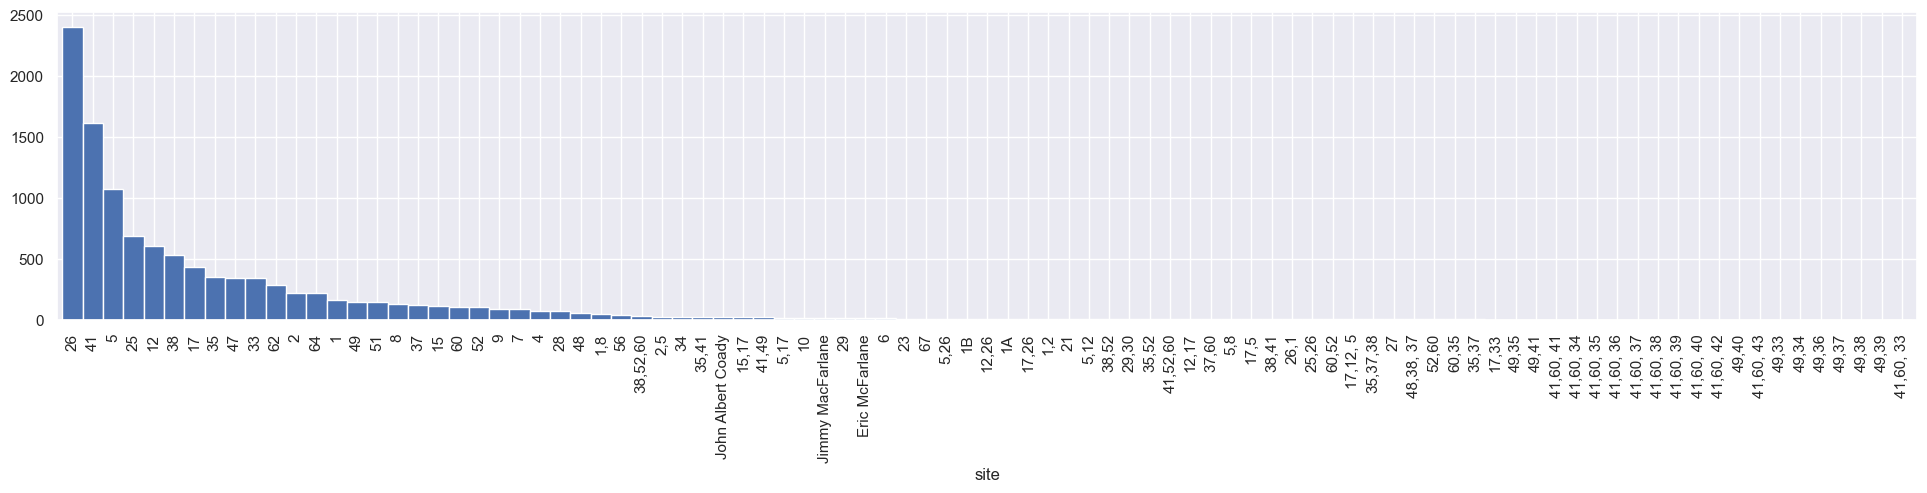

In [39]:
# let's check some stuff first
df_LF.groupby('site').count()['id'].sort_values(ascending=False).plot(kind='bar', figsize=(24, 4), width=1)
plt.show()

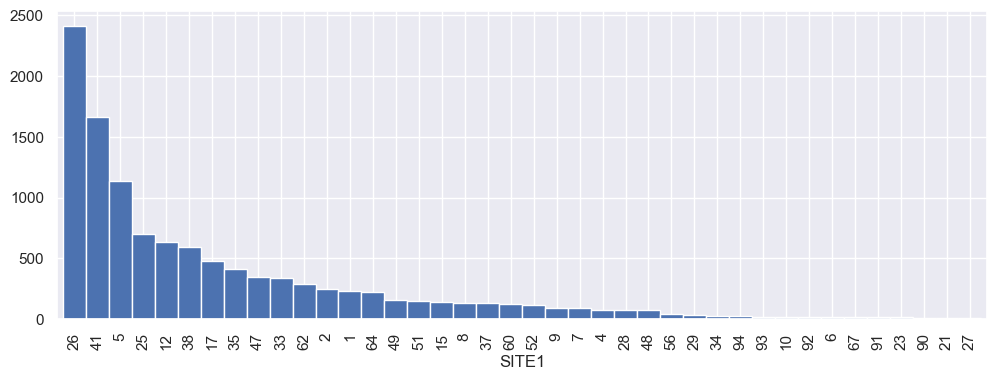

In [40]:
df_LF.groupby('SITE1').count()['id'].sort_values(ascending=False).plot(kind='bar', figsize=(12, 4), width=1)
plt.show()

In [41]:
# in SITE2 or SITE3, but never in SITE1
pd.DataFrame(list(LF_sites))[~pd.DataFrame(list(LF_sites)).isin(list(df_LF.groupby('SITE1').count()['id'].index))].dropna()

,0
0,43
9,30
13,40
17,36
36,39
39,42


In [42]:
df_SD.head()

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME
0,2,SWMARG,Darlene Cameron,NaN,81,11,NaN,1983,5,17,<NA>,18038.000,8181.900,14,lower,Cameron,NaN,NaN,NaN,NaN,11,<NA>,1983-05-17
1,2,SWMARG,Martin E Cameron,NaN,81,12,NaN,1983,5,16,<NA>,18038.000,8181.900,15,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-16
2,2,SWMARG,Martin E Cameron,NaN,81,12,NaN,1983,5,11,<NA>,17036.000,7727.400,14,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-11
3,2,SWMARG,Martin E Cameron,NaN,81,12,NaN,1983,5,18,<NA>,15032.000,6818.400,15,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-18
4,2,SWMARG,Martin E Cameron,NaN,81,12,NaN,1983,5,17,<NA>,13027.000,5908.900,15,lower,Cameron,NaN,NaN,NaN,NaN,12,<NA>,1983-05-17


In [43]:
# there are only 3 duplicates, so we're unlikely to have ambiguity
df_SD.groupby(['DATETIME', 'SITE1']).count()['SITE_NO'].sort_values(ascending=False).head()

DATETIME    SITE1
1988-05-23  48       2
1997-06-12  58       2
2004-06-10  1        2
2006-06-15  12       1
2006-06-13  41       1
Name: SITE_NO, dtype: int64

In [44]:
# not sure how there are more duplicates here than in SD, doesn't seem to make sense
df_LF[df_LF.new_sample].groupby(['DATETIME', 'SITE1']).count()['site'].sort_values(ascending=False).head(20)

DATETIME             SITE1
2000-06-09 00:00:00  26       2
1998-05-01 00:00:00  5        2
1993-06-04 00:00:00  26       2
1993-06-01 00:00:00  8        2
2018-06-13 00:00:00  64       2
2003-05-23 00:00:00  26       2
2000-06-07 00:00:00  26       2
1993-06-03 00:00:00  52       2
1993-06-09 00:00:00  33       2
2000-06-15 00:00:00  38       2
2001-05-16 00:00:00  5        2
2011-05-06 10:10:00  26       1
2011-05-11 10:15:00  41       1
2011-05-07 10:00:00  26       1
2011-05-10 11:45:00  26       1
2010-06-12 08:45:00  26       1
2010-06-11 09:00:00  41       1
2010-06-10 14:00:00  26       1
1990-05-08 00:00:00  5        1
2011-05-14 17:45:00  41       1
Name: site, dtype: int64